In [ ]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import tqdm.notebook as tq # better for notebook
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [ ]:
#import data
#rated = pd.read_csv("https://raw.githubusercontent.com/ArielNATAF/Books_project/dev/datasets/ratings.csv", usecols = ["user_id","book_id","rating"])
rated = pd.read_csv("https://raw.githubusercontent.com/ArielNATAF/Books_project/dev/datasets/ratings.csv", usecols = ["user_id","book_id"])
# the rated table has to be sorted for split_list()
rated = rated.sort_values('user_id').reset_index(drop=True)

books = pd.read_csv("https://raw.githubusercontent.com/ArielNATAF/Books_project/dev/datasets/books.csv", usecols =['book_id', 'original_title'])
rated.head()

,user_id,book_id
0,1,258
1,1,140
2,1,869
3,1,2679
4,1,1310


In [ ]:
users = rated["user_id"].unique().tolist()

rated['book_id']= rated['book_id'].astype(str)

len(users)

53424

In [ ]:

# extract 90% of customer ID's
user_train = [users[i] for i in range(round(0.9*len(users)))]

# split data into train and validation set
train_df = rated[rated["user_id"].isin(user_train)]
validation_df = rated[~rated["user_id"].isin(user_train)]

In [ ]:
rated_train = []

# populate the list with the product codes
for i in tqdm(user_train):
    temp = train_df[train_df["user_id"] == i]["book_id"].tolist()
    rated_train.append(temp)

100%|██████████| 48082/48082 [07:01<00:00, 114.20it/s]


In [ ]:
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)
#window (int, optional) – Maximum distance between the current and predicted word within a sentence.
#sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram; otherwise CBOW.
#hs ({0, 1}, optional) – If 1, hierarchical softmax will be used for model training. If 0, and negative is non-zero, negative sampling will be used.
#negative (int, optional) – If > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.
#alpha (float, optional) – The initial learning rate.
#min_alpha (float, optional) – Learning rate will linearly drop to min_alpha as training progresses.

model.build_vocab(rated_train, progress_per=200)

model.train(rated_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(53911854, 54035340)

In [ ]:
model.init_sims(replace=True)
print(model)
X = model[model.wv.vocab]

print(X.shape)


Word2Vec(vocab=10000, size=100, alpha=0.03)
(10000, 100)


In [ ]:
# books = pd.read_csv("https://raw.githubusercontent.com/ArielNATAF/Books_project/dev/datasets/books.csv", usecols =['book_id', 'original_title'])
books['book_id']= books['book_id'].astype(str)

books_dict = books.groupby('book_id')['original_title'].apply(list).to_dict()


def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (books_dict[j[0]][0], j[1])
        new_ms.append(pair)
    return new_ms        

In [ ]:
similar_products(model['117']) #117 -> a Wrinkle in time


[('The Phantom Tollbooth', 0.8389645218849182),
 ('From the Mixed-Up Files of Mrs. Basil E. Frankweiler', 0.7848960161209106),
 ('Bridge to Terabithia', 0.7499809265136719),
 ('Mrs. Frisby and the Rats of NIMH', 0.7358226776123047),
 ('The Giver', 0.7340474724769592),
 ('The Lion, the Witch and the Wardrobe', 0.7296534776687622)]

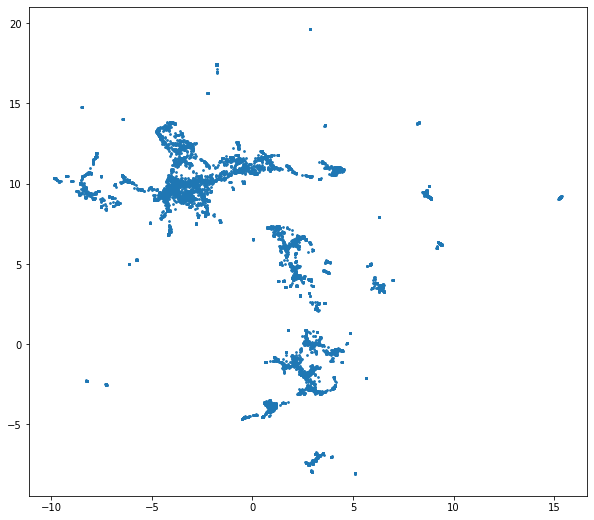

In [ ]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [ ]:
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel


     |████████████████████████████████| 81kB 3.0MB/s 
     |████████████████████████████████| 1.2MB 6.9MB/s 
     |████████████████████████████████| 15.8MB 272kB/s 
     |████████████████████████████████| 81kB 7.6MB/s 
     |████████████████████████████████| 112kB 44.1MB/s 
     |████████████████████████████████| 686kB 40.3MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=bd1e20f6eeca5a73fe3ef4852d7776e4485aefef6be38944b4c9fc87bef58ef4
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=f7c08af90a4241eed1ad14f4b9798ba75952df249367fd2d35723e2e29c86261
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
  Created wheel for datashape: filename=datashape-0.5.2-cp37-none-any.whl size=59430 sha256=cfd99e06698e08a6968f8f7f337fd0f61bfb5eece93